In [7]:
'''
Resources:
https://towardsdatascience.com/how-to-solve-the-traveling-salesman-problem-a-comparative-analysis-39056a916c9f
https://github.com/syakoo/simulated-annealing
https://towardsdatascience.com/how-to-solve-travelling-salesman-problem-with-simulated-annealing-c248447a8bcd
https://towardsdatascience.com/simulated-annealing-with-restart-a19a53d914c8
https://github.com/jedrazb/python-tsp-simulated-annealing
https://en.wikipedia.org/wiki/2-opt

'''

import math
import random
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
class tsp_utils:
    #Convert coordant information into distance matrix commonly used in TSP Problems
    def vectorToDistMatrix(coords):
        '''
        Create the distance matrix
        '''
        return np.sqrt((np.square(coords[:, np.newaxis] - coords).sum(axis=2)))


    def nearestNeighbourSolution(dist_matrix):
        '''
        Computes the initial solution (nearest neighbour strategy)
        '''
        #grabs random node in the size of the matrix
        node = random.randrange(len(dist_matrix))
        #stores node in result list
        result = [node]
        #sets nodes to visit equal to the size of the distance matrix
        nodes_to_visit = list(range(len(dist_matrix)))
        #removes first node
        nodes_to_visit.remove(node)
        #goes through and tries to find the nearest neighbour for every node
        while nodes_to_visit:
            nearest_node = min([(dist_matrix[node][j], j) for j in nodes_to_visit], key=lambda x: x[0])
            node = nearest_node[1]
            nodes_to_visit.remove(node)
            result.append(node)

        return result


In [8]:
#Class to store the data generated by the anealing algorithm
class solution:
    def __init__(self, coords):
        #converts data form coordants into distmatrix
        self.dist_matrix = tsp_utils.vectorToDistMatrix(coords)
        #uses distance matrix to find solution
        self.saved_solution = tsp_utils.nearestNeighbourSolution(self.dist_matrix)

    def __iter__(self):
        return self

    def get_matrix(self):
        return self.dist_matrix    
    def get_solution(self):
        return self.saved_solution    

In [9]:
class MSA:
    def __init__(self,coords, iterations, temp, gamma, stopping_temp):
        
        #intial coordant points
        self.coords = coords
        #size of array
        self.sample_size = len(coords)
        #initialize iteration counter
        self.iteration = 1
        #check point to stop iterations
        self.stopping_iter = iterations

        #tempature 
        self.temp = temp
        #tempature to stop program
        self.stopping_temp = stopping_temp
        #self.df = df
        #gamma value to multiply tempature by
        self.gamma = gamma
        #tmp varible to store the data in the solution object
        self.tmp_obj = solution(coords)
        #current solution based on the return value fo the object
        self.current = self.tmp_obj.get_solution()
        #gets the distance matrix from the object
        self.matrix = self.tmp_obj.get_matrix()
        #saves all the solutions in a list
        self.solution_history = [self.current]
        #saves the current solution as the best solution
        self.best = self.current
        #saves the weight as the current weight
        self.cweight = self.weight(self.current)
        #saves the current weight as the immediate weight weight of current solution
        self.iweight = self.cweight
        #saves the current weight as the minimum weight
        self.mweight = self.cweight
        #saves the weights into a list
        self.weight_list = [self.cweight]
        #prints the immediate weight
        print('Intial weight: ', self.iweight)

    #unused function to calcuate distance
    @staticmethod
    def total_distance(df):

        def euclidean_distance(x1, x2, y1, y2):
            return np.sqrt((x1-x2)**2+(y1-y2)**2)

        distance = 0
        for idx in range(0, len(df)):
            if idx + 1 >= len(df):
                break
            distance += euclidean_distance(df['x'].loc[idx], df['x'].loc[idx+1],
                                           df['y'].loc[idx], df['y'].loc[idx+1])
        return distance

    def weight(self, sol):
        
        #Calcuate weight

        return sum([self.matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def probability(self, candidate_weight):
        '''
        Acceptance probability as described in:
        https://stackoverflow.com/questions/19757551/basics-of-simulated-annealing-in-python
        '''
        return math.exp(-abs(candidate_weight - self.cweight) / self.temp)

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        #sets the canidate_weight as the weight of the current solution being tested
        candidate_weight = self.weight(candidate)
        #if the candiate weight is better than the current weight then the current solution is updated with the candiate infromation as well as the miniumm weight is checked and updated based on the canidate information
        if candidate_weight < self.cweight:
            self.cweight = candidate_weight
            self.current = candidate
            if candidate_weight < self.mweight:
                self.mweight = candidate_weight
                self.best_solution = candidate
        #if the candiate_weight is not better than than the current weight it is run through the probabilty function and if that probibility is less than the random that candidate is saved as the current weight
        else:
            if random.random() < self.probability(candidate_weight):
                self.cweight = candidate_weight
                self.current = candidate


    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        #if the tempt threshold or the iteration threshold is not reached then it continues through the while loop
        while self.temp >= self.stopping_temp and self.iteration < self.stopping_iter:
            #candidate is set to the current solution value
            candidate = list(self.current)
            #l and I are randomly generated based on the sample size defined above
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)
            #goes through each element of the candiate based on the randomly generated values and reverses them 
            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])
            #the reversed canidate is passed through the acceptance check if it passes the current information will be updated for the next look
            self.accept(candidate)
            #the tempiture is decreased based on the predefined gamma value
            self.temp *= self.gamma
            #an itteration is added
            self.iteration += 1
            #the weight list is appened wit the current weight
            self.weight_list.append(self.cweight)
            #the solution history is appended with the current solution 
            self.solution_history.append(self.current)

        #once the loop finishes the minimum weight is printed
        print('Minimum weight: ', self.mweight)
        #improvemnt calculation based on the starting weight and the minimum weight
        print('Improvement: ',
              round((self.iweight - self.mweight) / (self.iweight), 4) * 100, '%')

    #plot the output of the solutions
    def plotLearning(self):
        #plot the weight graph
        plt.plot([i for i in range(len(self.weight_list))], self.weight_list)
        line_init = plt.axhline(y=self.iweight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.mweight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        #plt.show()

    def plotResults(self,name):
        #set up figure
        fig, ax = plt.subplots()
        #set line weight
        line, = plt.plot([], [], lw=2)
        ''' initialize node dots on graph '''
        x = [self.coords[i][0] for i in self.solution_history[0]]
        y = [self.coords[i][1] for i in self.solution_history[0]]
        plt.plot(x, y, 'co')

        ''' draw axes slighty bigger  '''
        extra_x = (max(x) - min(x)) * 0.05
        extra_y = (max(y) - min(y)) * 0.05
        ax.set_xlim(min(x) - extra_x, max(x) + extra_x)
        ax.set_ylim(min(y) - extra_y, max(y) + extra_y)
        #draw last solution on the graph using the starting solutions points and the last solutions lines
        x = [self.coords[i, 0] for i in self.solution_history[len(self.solution_history)-1] + [self.solution_history[len(self.solution_history)-1][0]]]
        y = [self.coords[i, 1] for i in self.solution_history[len(self.solution_history)-1] + [self.solution_history[len(self.solution_history)-1][0]]]
        #set lines
        line.set_data(x, y)
        #add lable to print the final weight
        plt.xlabel('Weight:'+str(self.mweight))
        #create path to images
        if not os.path.exists("./images"):
            os.mkdir("./images")
        #save the plot for the graph based on the imput name with the default being city_final
        plt.savefig("./images/"+name)
        #plt.show
    def get_mweight(self):
        #get minimum weight
        return self.mweight
    



In [10]:
#run funtion with all the data needed
def run(nodes,stopping_iter, temp, gamma, stopping_temp,name="cities_final.png", weight= np.Inf ):
    '''run simulated annealing algorithm with 2-opt'''
    #run simulated annealing
    sa = MSA(nodes,stopping_iter, temp, gamma, stopping_temp)

    sa.anneal()
    #set base weight first itteration is infinity
    current_weight = weight
    # get min_weight from the simulated annealing instance
    min_wieght = sa.get_mweight()
    '''animate'''
    
    #sa.animateSolutions()
    '''show the improvement over time'''
    if(min_wieght<current_weight):
        #if the min_weight is less than the current weight then the plot for that annealing is generated and the new minweight is returend
        sa.plotLearning()
        sa.plotResults(name)
        return min_wieght
    else:
        #else the current weight is returned
        return current_weight
    

Intial weight:  4.3580045910318415
Minimum weight:  3.604705284291183
Improvement:  17.29 %


3.604705284291183

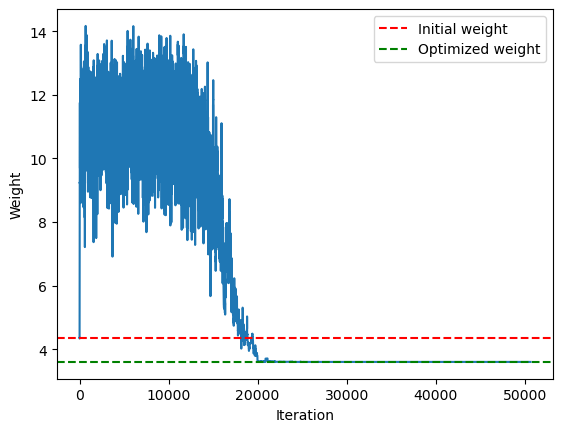

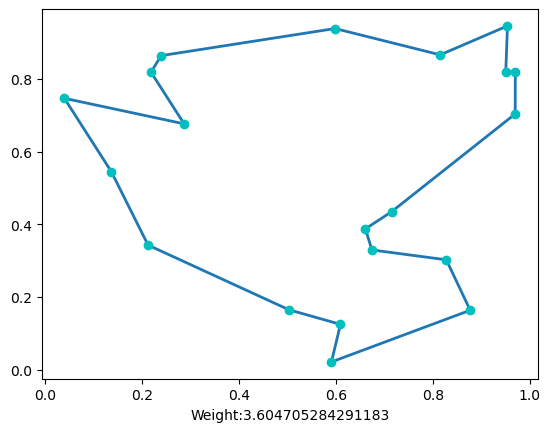

In [11]:
    '''set the simulated annealing algorithm params'''
    #test run based on wrong points
temp = 1000
stopping_temp = 0.00000001
gamma = 0.9995
stopping_iter = 10000000
xs = [0.6606,0.9695,0.5906, 0.2124, 0.0398, 0.1367,0.9536,0.6091,0.8767,0.8148,0.9500,0.6740,0.5029,0.8274,0.9697,0.5979,0.2184,0.7148,0.2395,0.2867]
ys = [0.3876,0.7041,0.0213,0.3429,0.7471,0.5449,0.9464,0.1247,0.1636,0.8668,0.8200,0.3296,0.1649,0.3025,0.8192,0.9392,0.8191,0.4351,0.8646,0.6768]
#print(f"X: {d} && Y:{s}",len(xs),len(ys))
nodes = np.column_stack((xs, ys))
run(nodes,stopping_iter, temp, gamma, stopping_temp)

Intial weight:  5.014274936724524
Minimum weight:  4.030656182592688
Improvement:  19.62 %
Intial weight:  4.502090428504454
Minimum weight:  4.076046089443103
Improvement:  9.46 %
Intial weight:  4.444147300922404
Minimum weight:  4.076046089443103
Improvement:  8.28 %
Intial weight:  4.8067459348638515
Minimum weight:  4.076046089443103
Improvement:  15.2 %
Intial weight:  5.452254618497038
Minimum weight:  4.054910629557462
Improvement:  25.629999999999995 %
Intial weight:  5.22894797811956
Minimum weight:  4.076046089443103
Improvement:  22.05 %
Intial weight:  4.909123268390923
Minimum weight:  4.030656182592689
Improvement:  17.89 %
Intial weight:  4.8322153627319455
Minimum weight:  4.030656182592688
Improvement:  16.59 %
Intial weight:  4.986850665914826
Minimum weight:  4.030656182592688
Improvement:  19.17 %
Intial weight:  4.908185133302875
Minimum weight:  4.076046089443103
Improvement:  16.950000000000003 %
Intial weight:  5.014274936724524
Minimum weight:  4.0760460894431

<function matplotlib.pyplot.show(close=None, block=None)>

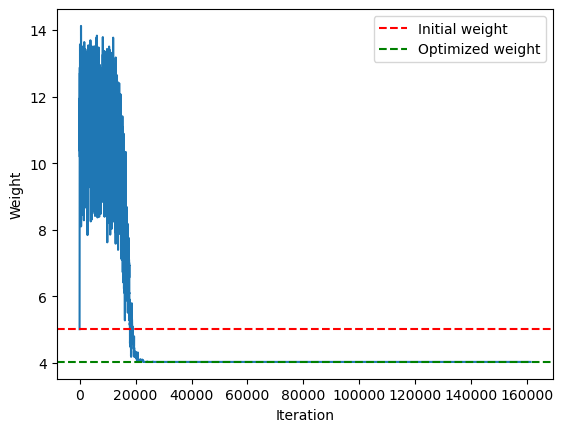

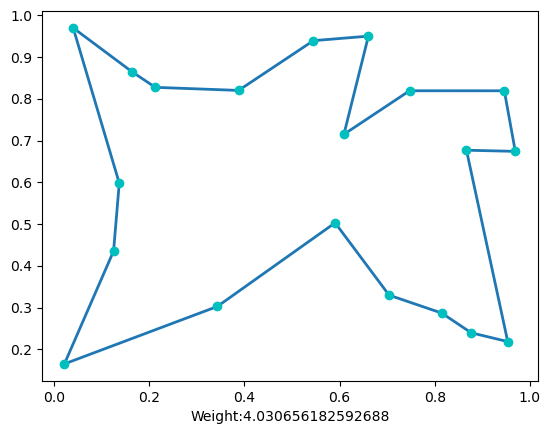

In [12]:
#actia run
temp = 1000
stopping_temp = 0.00000000000000000000000000000001
gamma = 0.9995
stopping_iter = 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
xs = [0.6606,0.9695,0.5906, 0.2124, 0.0398, 0.1367,0.9536,0.6091,0.8767,0.8148,0.3876,0.7041,0.0213,0.3429,0.7471,0.5449,0.9464,0.1247,0.1636,0.8668]
ys = [0.9500,0.6740,0.5029,0.8274,0.9697,0.5979,0.2184,0.7148,0.2395,0.2867,0.8200,0.3296,0.1649,0.3025,0.8192,0.9392,0.8191,0.4351,0.8646,0.6768]
#print(f"X: {d} && Y:{s}",len(xs),len(ys))
nodes = np.column_stack((xs, ys))
name="HW Question 1.png"
weight = np.inf
#for loop that run through the map 20 times to get the attempt the best solution 
for i in range(0,20):
    weight = run(nodes,stopping_iter, temp, gamma, stopping_temp,name, weight)


plt.show

In [13]:
#data for the 101 cities
data = [1, 41, 49, 2, 35, 17, 3, 55, 45, 4, 55, 20, 5, 15, 30, 6, 25, 30, 7, 20, 50, 8, 10, 43, 9, 55, 60, 10, 30, 60, 11, 20, 65, 12, 50, 35, 13, 30, 25, 14, 15, 10, 15, 30, 5, 16, 10, 20, 17, 5, 30, 18, 20, 40, 19, 15, 60, 20, 45, 65, 21, 45, 20, 22, 45, 10, 23, 55, 5, 24, 65, 35, 25, 65, 20, 26, 45, 30, 27, 35, 40, 28, 41, 37, 29, 64, 42, 30, 40, 60, 31, 31, 52, 32, 35, 69, 33, 53, 52, 34, 65, 55, 35, 63, 65, 36, 2, 60, 37, 20, 20, 38, 5, 5, 39, 60, 12, 40, 40, 25, 41, 42, 7, 42, 24, 12, 43, 23, 3, 44, 11, 14, 45, 6, 38, 46, 2, 48, 47, 8, 56, 48, 13, 52, 49, 6, 68, 50, 47, 47, 51, 49, 58, 52, 27, 43, 53, 37, 31, 54, 57, 29, 55, 63, 23, 56, 53, 12, 57, 32, 12, 58, 36, 26, 59, 21, 24, 60, 17, 34, 61, 12, 24, 62, 24, 58, 63, 27, 69, 64, 15, 77, 65, 62, 77, 66, 49, 73, 67, 67, 5, 68, 56, 39, 69, 37, 47, 70, 37, 56, 71, 57, 68, 72, 47, 16, 73, 44, 17, 74, 46, 13, 75, 49, 11, 76, 49, 42, 77, 53, 43, 78, 61, 52, 79, 57, 48, 80, 56, 37, 81, 55, 54, 82, 15, 47, 83, 14, 37, 84, 11, 31, 85, 16, 22, 86, 4, 18, 87, 28, 18, 88, 26, 52, 89, 26, 35, 90, 31, 67, 91, 15, 19, 92, 22, 22, 93, 18, 24, 94, 26, 27, 95, 25, 24, 96, 22, 27, 97, 25, 21, 98, 19, 21, 99, 20, 26, 100, 18, 18, 101, 35, 35]

Intial weight:  765.5261608558586
Minimum weight:  625.3917060643012
Improvement:  18.310000000000002 %
Intial weight:  721.3758284564734
Minimum weight:  668.5266973498684
Improvement:  7.33 %
Intial weight:  738.5188202977614
Minimum weight:  633.2878190436267
Improvement:  14.249999999999998 %
Intial weight:  718.1690276678853
Minimum weight:  630.9923471175688
Improvement:  12.139999999999999 %
Intial weight:  690.4244499371883
Minimum weight:  656.5884713316545
Improvement:  4.9 %
Intial weight:  739.7171044878103
Minimum weight:  635.9543103610816
Improvement:  14.030000000000001 %
Intial weight:  716.8068069288466
Minimum weight:  631.4209182484159
Improvement:  11.91 %
Intial weight:  757.5822449590481
Minimum weight:  652.6573300302492
Improvement:  13.850000000000001 %
Intial weight:  714.5547584686362
Minimum weight:  651.4843068627639
Improvement:  8.83 %
Intial weight:  718.1690276678853
Minimum weight:  637.3444681942419
Improvement:  11.25 %
Intial weight:  757.582244959

<function matplotlib.pyplot.show(close=None, block=None)>

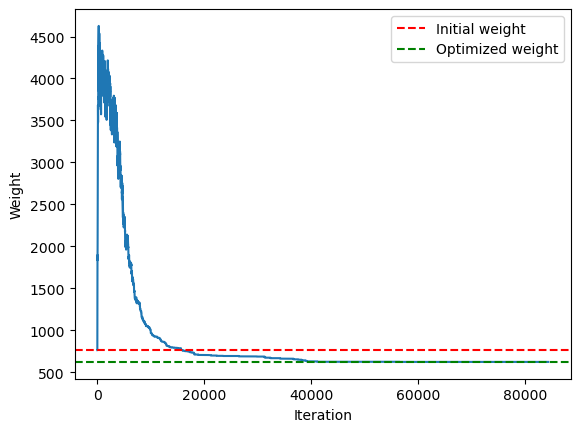

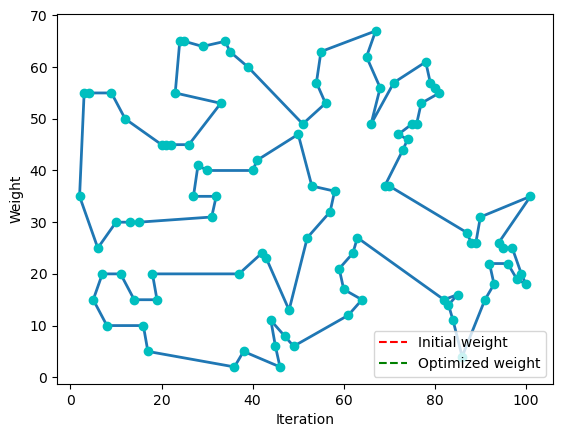

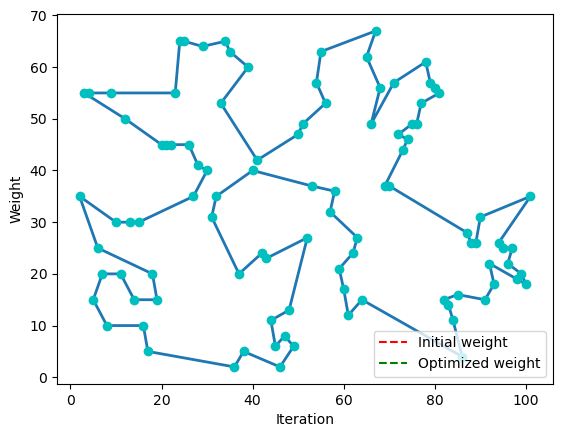

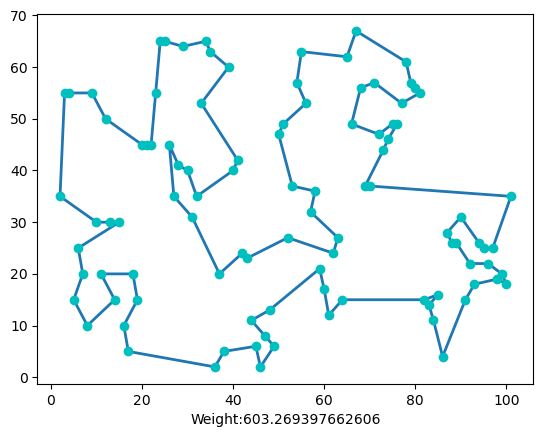

In [15]:
#take every third data value for the number of each city
value = data[::3]
#pop off the first value
data.pop(0)
#get all the x valeus for the cities
xs = data[::3]
#pop again
data.pop(0)
#get all the y values
ys = data[::3]





#settings
temp = 200
stopping_temp = 0.0000000000000001
gamma = 0.9995
stopping_iter = 100000000000000000000000000000000000000000
#make array with x and y
nodes = np.column_stack((xs, ys))
#name the saved graph
name="HW Question 2.png"

weight = np.inf
#run 30 times
for i in range(0,30):
    #feedback the returned weight
    weight = run(nodes,stopping_iter, temp, gamma, stopping_temp,name, weight)


plt.show
#idk why the charts for this one mess up 